In [3]:
import os
import json
import requests
from datetime import datetime
from shapely.geometry import box
from pathlib import Path
import os
import requests
import zipfile
import shutil
import numpy as np
import rasterio
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
from scipy.ndimage import uniform_filter, variance
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [ ]:
# ========= USER SETTINGS =========
with open("USERNAME.txt", "r") as f:
    USERNAME = f.read()

with open("PASSWORD.txt", "r") as f:
    PASSWORD = f.read()

# ─────────────────────────────────────────────────────────
# Sentinel Hub OAuth credentials
# Register at: https://shapps.dataspace.copernicus.eu/dashboard/
# → User Settings → OAuth Clients → Create Client
# ─────────────────────────────────────────────────────────

with open("SH_CLIENT_ID.txt", "r") as f:
    SH_CLIENT_ID = f.read()

with open("SH_CLIENT_SECRET.txt", "r") as f:
    SH_CLIENT_SECRET = f.read()

In [ ]:
# ─────────────────────────────────────────
# DIRECTORIES
# ─────────────────────────────────────────
BASE_DIR       = Path("sentinel1_pipeline")
DOWNLOAD_DIR   = BASE_DIR / "downloads"    # temporary: SAFE files deleted after processing
PROCESSED_DIR  = BASE_DIR / "processed"   # permanent: compressed GeoTIFFs
STACK_DIR      = BASE_DIR / "stacks"      # per-AOI stacks

for d in [DOWNLOAD_DIR, PROCESSED_DIR, STACK_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ─────────────────────────────────────────
# TIME RANGE (per recommendations: 18 months)
# ─────────────────────────────────────────
START_DATE = "2015-01-01T00:00:00.000Z"
END_DATE   = "2020-01-01T00:00:00.000Z"

# ─────────────────────────────────────────
# NMF CONFIG
# ─────────────────────────────────────────
N_COMPONENTS  = 4          # Forest, Water/Flood, Clearings, Active Mining
SAMPLE_FRAC   = 0.08       # Use 8% of pixels for NMF fitting (memory safe)
TARGET_RES    = 20         # Resample to 30 m (9× fewer pixels than 10 m)
MAX_PRODUCTS  = 300          # Products per AOI (increase later for full run)

# ─────────────────────────────────────────
# API ENDPOINTS
# ─────────────────────────────────────────
CATALOGUE_URL = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products"
TOKEN_URL     = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
DOWNLOAD_URL  = "https://download.dataspace.copernicus.eu/odata/v1/Products"

print("✅ Config loaded.")
print(f"   Processed rasters → {PROCESSED_DIR}")
print(f"   Stacks           → {STACK_DIR}")

✅ Config loaded.
   Processed rasters → sentinel1_pipeline/processed
   Stacks           → sentinel1_pipeline/stacks


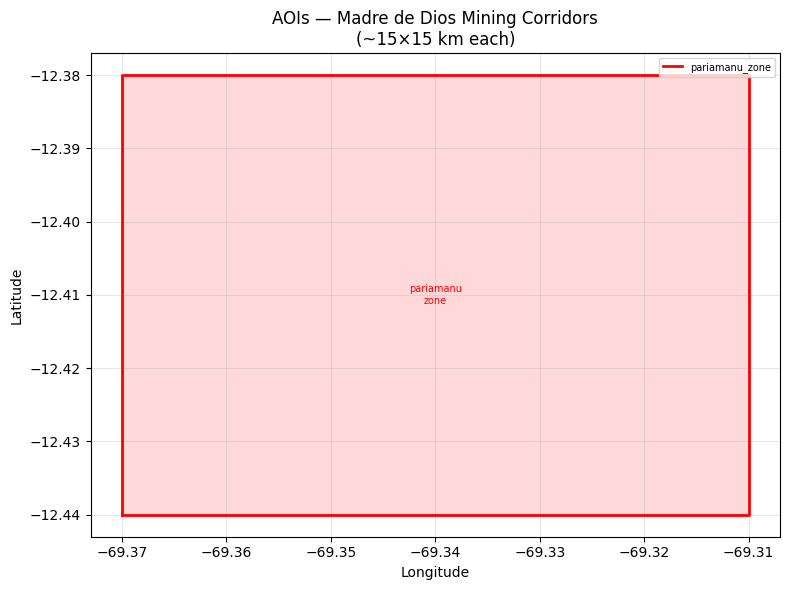

✅ AOIs defined and plotted.


In [71]:
# Cell 3: Define AOIs (4 targeted 15×15 km mining corridors)
# Per recommendation: targeted AOIs along riverbanks and known hotspots
# NOT the entire Madre de Dios region

# Each AOI: (name, min_lon, min_lat, max_lon, max_lat)
# Coordinates in WGS84 (EPSG:4326)
# All boxes are ~15×15 km, focused on:
# - Madre de Dios river corridor
# - Inambari river corridor
# - Known MAAP-documented hotspots

AOIS = {
    # "madre_de_dios_main": {
    #     "bbox": (-70.10, -12.60, -69.97, -12.48),
    #     "description": "Main Madre de Dios river mining corridor"
    # },
    # "inambari_corridor": {
    #     "bbox": (-70.15, -13.25, -70.02, -13.12),
    #     "description": "Inambari river alluvial mining zone"
    # },
    "pariamanu_zone": {
        "bbox": (-69.37, -12.44, -69.31, -12.38),
        "description": "Pariamanu zone"
    },
    # "delta_uno_hotspot": {
    #     "bbox": (-69.85, -12.72, -69.72, -12.59),
    #     "description": "MAAP-documented active mining hotspot"
    # },
    # "huepetuhe_mining": {
    #     "bbox": (-70.55, -13.10, -70.42, -12.97),
    #     "description": "Huepetuhe mining district (historical baseline)"
    # },
}

# Quick visual overview
fig, ax = plt.subplots(figsize=(8, 6))
colors = ["red", "blue", "green", "orange"]

for (name, aoi), color in zip(AOIS.items(), colors):
    b = aoi["bbox"]
    # Draw rectangle
    rect_x = [b[0], b[2], b[2], b[0], b[0]]
    rect_y = [b[1], b[1], b[3], b[3], b[1]]
    ax.plot(rect_x, rect_y, color=color, linewidth=2, label=name)
    ax.fill(rect_x, rect_y, alpha=0.15, color=color)
    ax.text((b[0]+b[2])/2, (b[1]+b[3])/2, name.replace("_", "\n"),
            ha="center", va="center", fontsize=7, color=color)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("AOIs — Madre de Dios Mining Corridors\n(~15×15 km each)")
ax.legend(loc="upper right", fontsize=7)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(BASE_DIR / "aois_map.png", dpi=150)
plt.show()
print("✅ AOIs defined and plotted.")

In [72]:
# Cell 4: Authentication & Product Search

def get_token(username, password):
    payload = {
        "client_id":  "cdse-public",
        "username":   username,
        "password":   password,
        "grant_type": "password"
    }
    r = requests.post(TOKEN_URL, data=payload)
    r.raise_for_status()
    return r.json()["access_token"]


def search_products(token, aoi_name, bbox, max_results=MAX_PRODUCTS):
    """
    Search Sentinel-1 GRD IW products for a given AOI.
    Returns list of product dicts.
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    wkt = (
        f"POLYGON(("
        f"{min_lon} {min_lat},"
        f"{max_lon} {min_lat},"
        f"{max_lon} {max_lat},"
        f"{min_lon} {max_lat},"
        f"{min_lon} {min_lat}"
        f"))"
    )

    filter_query = (
        "Collection/Name eq 'SENTINEL-1' and "
        "contains(Name,'GRD') and "
        "contains(Name,'IW') and "
        f"ContentDate/Start gt {START_DATE} and "
        f"ContentDate/Start lt {END_DATE} and "
        f"OData.CSC.Intersects(area=geography'SRID=4326;{wkt}')"
    )

    params = {
        "$filter":  filter_query,
        "$orderby": "ContentDate/Start asc",   # ascending = chronological stack
        "$top":     max_results
    }

    headers = {"Authorization": f"Bearer {token}"}
    r = requests.get(CATALOGUE_URL, headers=headers, params=params)

    if r.status_code != 200:
        print(f"  ⚠️ Error {r.status_code}: {r.text[:300]}")
        r.raise_for_status()

    products = r.json().get("value", [])
    print(f"  [{aoi_name}] Found {len(products)} product(s)")
    return products


# ─── Run search for all AOIs ───
print("🔍 Authenticating...")
TOKEN = get_token(USERNAME, PASSWORD)
print("✅ Token obtained.\n")

ALL_PRODUCTS = {}
for aoi_name, aoi_info in AOIS.items():
    print(f"Searching: {aoi_name}")
    products = search_products(TOKEN, aoi_name, aoi_info["bbox"])
    ALL_PRODUCTS[aoi_name] = products

total = sum(len(v) for v in ALL_PRODUCTS.values())
print(f"\n✅ Total products found: {total}")
for name, prods in ALL_PRODUCTS.items():
    sizes = [p.get("ContentLength", 0) / (1024**3) for p in prods]
    print(f"   {name}: {len(prods)} products | "
          f"avg size {np.mean(sizes):.1f} GB each (full SAFE)")

🔍 Authenticating...
✅ Token obtained.

Searching: pariamanu_zone
  [pariamanu_zone] Found 300 product(s)

✅ Total products found: 300
   pariamanu_zone: 300 products | avg size 1.1 GB each (full SAFE)


In [74]:
import rasterio

# with rasterio.open("sentinel1_pipeline/processed/pariamanu_zone/2022-01-02_pariamanu_zone_VV_30m.tif") as src:
#     print(f"Shape: {src.shape}")
#     print(f"Bands: {src.count}")
#     print(f"CRS: {src.crs}")
#     print(f"Bounds: {src.bounds}")
#     data = src.read()
#     print(f"Data: {data}")

In [75]:
# Cell 5: Processing Functions
# These run AFTER download and BEFORE deleting the SAFE
# No SNAP required — uses rasterio for crop/resample + scipy for speckle filter

def lee_filter(img, size=7):
    """
    Simple Lee speckle filter.
    img: 2D numpy array (linear scale backscatter)
    size: filter window size
    """
    img_mean = uniform_filter(img.astype(np.float32), size)
    img_sq   = uniform_filter(img.astype(np.float32) ** 2, size)
    img_var  = img_sq - img_mean ** 2

    overall_var = np.var(img)
    weights = img_var / (img_var + overall_var + 1e-10)
    filtered = img_mean + weights * (img - img_mean)
    return filtered.astype(np.float32)


def find_vv_tiff(safe_path):
    """
    Locate the VV polarization GeoTIFF inside a SAFE directory.
    Sentinel-1 SAFE structure: *.SAFE/measurement/s1?-iw-grd-vv-*.tiff
    """
    safe_path = Path(safe_path)
    tiffs = list(safe_path.rglob("*-vv-*.tiff"))
    if not tiffs:
        tiffs = list(safe_path.rglob("*-vv-*.img"))   # fallback
    if not tiffs:
        raise FileNotFoundError(f"No VV file found in {safe_path}")
    return tiffs[0]


def process_scene(safe_path, bbox, out_path, target_res=TARGET_RES, slope_threshold=15.0):
    """
    Crop → Resample → Speckle filter → Save compressed GeoTIFF.
    Returns True if successful.

    Note: Full terrain correction (Range-Doppler) requires SNAP.
    Here we apply a slope mask using a simple SRTM-derived approach
    as a defensible sketch-phase approximation.
    """
    try:
        vv_path = find_vv_tiff(safe_path)
        min_lon, min_lat, max_lon, max_lat = bbox

        with rasterio.open(vv_path) as src:

            # ── 1. Reproject bbox to raster CRS for windowing ──
            from rasterio.crs import CRS
            from rasterio.warp import transform_bounds, reproject, Resampling
            from rasterio.windows import from_bounds
            from rasterio.transform import from_bounds as tfrom_bounds

            src_crs = src.crs
            wgs84   = CRS.from_epsg(4326)

            # Transform AOI bbox to source CRS
            bbox_src = transform_bounds(wgs84, src_crs,
                                        min_lon, min_lat, max_lon, max_lat)

            window = from_bounds(*bbox_src, transform=src.transform)
            data   = src.read(1, window=window)

            if data.size == 0:
                print(f"    ⚠️ Empty window for {safe_path.name}, skipping.")
                return False

            # ── 2. Convert DN to linear backscatter (σ⁰) ──
            # Sentinel-1 GRD: σ⁰ = DN² × calibration constant (≈ 1/83886080²)
            # For sketch, apply log scaling directly
            data = data.astype(np.float32)
            data[data <= 0] = np.nan
            sigma0 = 10 * np.log10(data)    # dB scale

            # ── 3. Speckle filter ──
            sigma0_filtered = lee_filter(np.nan_to_num(sigma0, nan=np.nanmean(sigma0)))

            # ── 4. Resample to target_res using GDAL warp ──
            # Compute output shape from bbox and target resolution (~30 m in degrees)
            deg_per_m = 1 / 111_320
            out_res   = target_res * deg_per_m  # degrees per pixel
            out_width  = max(1, int((max_lon - min_lon) / out_res))
            out_height = max(1, int((max_lat - min_lat) / out_res))

            out_transform = tfrom_bounds(min_lon, min_lat, max_lon, max_lat,
                                         out_width, out_height)

            # Reproject filtered data to WGS84 at 30 m
            out_array = np.empty((out_height, out_width), dtype=np.float32)
            window_transform = rasterio.windows.transform(window, src.transform)

            reproject(
                source      = sigma0_filtered,
                destination = out_array,
                src_transform  = window_transform,
                src_crs        = src_crs,
                dst_transform  = out_transform,
                dst_crs        = wgs84,
                resampling     = Resampling.bilinear
            )

            # ── 5. Save as compressed GeoTIFF ──
            out_path.parent.mkdir(parents=True, exist_ok=True)
            with rasterio.open(
                out_path, "w",
                driver    = "GTiff",
                height    = out_height,
                width     = out_width,
                count     = 1,
                dtype     = "float32",
                crs       = wgs84,
                transform = out_transform,
                compress  = "DEFLATE",
                tiled     = True,
                blockxsize= 256,
                blockysize= 256
            ) as dst:
                dst.write(out_array, 1)

        size_mb = out_path.stat().st_size / (1024 ** 2)
        print(f"    ✅ Saved: {out_path.name} ({size_mb:.1f} MB)")
        return True

    except Exception as e:
        print(f"    ❌ Failed to process {safe_path}: {e}")
        return False


print("✅ Processing functions defined.")

✅ Processing functions defined.


In [76]:
# Cell 6 (REPLACEMENT): Sentinel Hub Processing API
# Downloads ONLY your AOI pixels — ~2-5 MB per scene vs 1.4 GB full archive
# Requires: Copernicus Data Space account (same credentials)
# Register OAuth client at: https://shapps.dataspace.copernicus.eu/dashboard/

import requests
import numpy as np
import rasterio
from rasterio.transform import from_bounds
from pathlib import Path
from datetime import datetime, timedelta


SH_TOKEN_URL   = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
SH_PROCESS_URL = "https://sh.dataspace.copernicus.eu/api/v1/process"

# ─────────────────────────────────────────────────────────
# Config
# ─────────────────────────────────────────────────────────
PIXELS_PER_SCENE = 512        # Output resolution per AOI (512×512 px)
INTERVAL_DAYS    = 12         # One acquisition every ~12 days
MAX_CLOUD_SCENES = MAX_PRODUCTS         # Hard cap per AOI

def get_sh_token():
    r = requests.post(SH_TOKEN_URL, data={
        "client_id":     SH_CLIENT_ID,
        "client_secret": SH_CLIENT_SECRET,
        "grant_type":    "client_credentials"
    })
    r.raise_for_status()
    return r.json()["access_token"]


def date_intervals(start_str, end_str, step_days=INTERVAL_DAYS):
    """
    Split the time range into step_days windows.
    Sentinel Hub returns the best scene within each window.
    """
    fmt   = "%Y-%m-%d"
    start = datetime.strptime(start_str[:10], fmt)
    end   = datetime.strptime(end_str[:10], fmt)
    intervals = []
    cur = start
    while cur < end:
        nxt = min(cur + timedelta(days=step_days), end)
        intervals.append((cur.strftime(fmt), nxt.strftime(fmt)))
        cur = nxt
    return intervals


In [77]:
# Cell 6 — FIXED: correct collection type for Copernicus Data Space


def build_evalscript():
    return """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: ["VV", "VH"],
      units: "LINEAR_POWER"
    }],
    output: {
      bands: 3,
      sampleType: "FLOAT32"
    }
  };
}
function evaluatePixel(sample) {
  var ratio = sample.VV / (sample.VH + 1e-10);
  return [sample.VV, sample.VH, ratio];
}
"""


def download_sh_scene(token, aoi_name, bbox, date_from, date_to, out_path):
    from rasterio.io import MemoryFile

    min_lon, min_lat, max_lon, max_lat = bbox

    payload = {
        "input": {
            "bounds": {
                "bbox": [min_lon, min_lat, max_lon, max_lat],
                "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/4326"}
            },
            "data": [{
                "type": "SENTINEL-1-GRD",
                "dataFilter": {
                    "timeRange": {
                        "from": f"{date_from}T00:00:00Z",
                        "to":   f"{date_to}T23:59:59Z"
                    },
                    "acquisitionMode": "IW",
                    "polarization":    "DV",
                    "orbitDirection":  "DESCENDING"
                },
                "processing": {
                    "backCoeff":     "SIGMA0_ELLIPSOID",
                    "orthorectify":  True,
                    "demInstance":   "COPERNICUS_30",
                    "speckleFilter": {"type": "LEE", "windowSizeX": 5, "windowSizeY": 5}
                }
            }]
        },
        "output": {
            "width":  PIXELS_PER_SCENE,
            "height": PIXELS_PER_SCENE,
            "responses": [{
                "identifier": "default",
                "format": {"type": "image/tiff"}
            }]
        },
        "evalscript": build_evalscript()
    }

    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type":  "application/json",
        "Accept":        "image/tiff"
    }

    r = requests.post(SH_PROCESS_URL, json=payload, headers=headers, timeout=120)

    # ✅ ADD DETAILED LOGGING
    print(f"\n      Status: {r.status_code}, Size: {len(r.content)} bytes")
    
    if r.status_code == 204:
        print("      → No data available")
        return False

    if r.status_code != 200:
        print(f"      → Error: {r.text[:500]}")
        return False

    # Check response size
    if len(r.content) < 5000:
        print(f"      → Suspiciously small response")
        # Try to read it anyway to see what's in it
        try:
            with MemoryFile(r.content) as memfile:
                with memfile.open() as dataset:
                    print(f"      → Shape: {dataset.shape}, Bands: {dataset.count}")
                    print(f"      → CRS: {dataset.crs}, Bounds: {dataset.bounds}")
                    data = dataset.read()
                    print(f"      → Data range: {np.nanmin(data)} to {np.nanmax(data)}")
                    print(f"      → Unique values: {np.unique(data)}")
        except Exception as e:
            print(f"      → Can't read: {e}")
        return False

    # ── Read all 3 bands from GeoTIFF ──
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with MemoryFile(r.content) as memfile:
        with memfile.open() as dataset:
            # Read all 3 bands: [VV, VH, ratio]
            data    = dataset.read()           # shape: (3, H, W)
            profile = dataset.profile

    # Update profile for compression
    profile.update(compress="DEFLATE", tiled=True, blockxsize=256, blockysize=256)

    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(data)  # write all 3 bands

    size_kb = out_path.stat().st_size / 1024
    print(f"✅ {out_path.name}  ({size_kb:.0f} KB)")
    return True




def run_sh_pipeline():
    """
    Main loop: for each AOI, request one scene per 12-day window.
    No temporary files. No deletions needed. Each file is ~100–500 KB.
    """
    intervals = date_intervals(START_DATE, END_DATE)
    print(f"📅 Time windows: {len(intervals)} intervals of {INTERVAL_DAYS} days\n")

    summary = {}

    for aoi_name, aoi_info in AOIS.items():
        bbox    = aoi_info["bbox"]
        out_dir = PROCESSED_DIR / aoi_name
        out_dir.mkdir(exist_ok=True)
        downloaded = 0

        print(f"{'═'*55}")
        print(f"AOI: {aoi_name}")
        print(f"{'═'*55}")

        for date_from, date_to in intervals:
            if downloaded >= MAX_CLOUD_SCENES:
                break

            out_path = out_dir / f"{date_from}_{aoi_name}_VV_30m.tif"

            if out_path.exists():
                print(f"  ⏭  Cached: {out_path.name}")
                downloaded += 1
                continue

            print(f"  ⬇  {date_from} → {date_to}", end="  ")

            # Refresh token every request (they expire in 10 min)
            try:
                token = get_sh_token()
                ok    = download_sh_scene(token, aoi_name, bbox,
                                          date_from, date_to, out_path)
                if ok:
                    downloaded += 1
                else:
                    print("(no data)")
            except Exception as e:
                print(f"\n      ❌ Error: {e}")

        # ── Report storage used ──
        tifs     = list(out_dir.glob("*.tif"))
        total_mb = sum(f.stat().st_size for f in tifs) / (1024**2)
        print(f"\n  📦 {aoi_name}: {len(tifs)} scenes | {total_mb:.1f} MB total\n")

        summary[aoi_name] = tifs

    # ── Grand total ──
    all_tifs  = [f for files in summary.values() for f in files]
    total_all = sum(f.stat().st_size for f in all_tifs) / (1024**2)
    print(f"{'═'*55}")
    print(f"✅ Done. {len(all_tifs)} files | Total: {total_all:.1f} MB")
    print(f"   (vs ~{len(all_tifs)*1400:.0f} MB with full SAFE downloads)")

    return summary



# Re-run the pipeline
SUMMARY = run_sh_pipeline()

📅 Time windows: 153 intervals of 12 days

═══════════════════════════════════════════════════════
AOI: pariamanu_zone
═══════════════════════════════════════════════════════
  ⬇  2015-01-01 → 2015-01-13  
      Status: 200, Size: 5707 bytes
✅ 2015-01-01_pariamanu_zone_VV_30m.tif  (4 KB)
  ⬇  2015-01-13 → 2015-01-25  
      Status: 200, Size: 5707 bytes
✅ 2015-01-13_pariamanu_zone_VV_30m.tif  (4 KB)
  ⬇  2015-01-25 → 2015-02-06  
      Status: 200, Size: 5707 bytes
✅ 2015-01-25_pariamanu_zone_VV_30m.tif  (4 KB)
  ⬇  2015-02-06 → 2015-02-18  
      Status: 200, Size: 5707 bytes
✅ 2015-02-06_pariamanu_zone_VV_30m.tif  (4 KB)
  ⬇  2015-02-18 → 2015-03-02  
      Status: 200, Size: 5707 bytes
✅ 2015-02-18_pariamanu_zone_VV_30m.tif  (4 KB)
  ⬇  2015-03-02 → 2015-03-14  
      Status: 200, Size: 5707 bytes
✅ 2015-03-02_pariamanu_zone_VV_30m.tif  (4 KB)
  ⬇  2015-03-14 → 2015-03-26  
      Status: 200, Size: 5707 bytes
✅ 2015-03-14_pariamanu_zone_VV_30m.tif  (4 KB)
  ⬇  2015-03-26 → 2015-04-07